# Airport recommendation

In [36]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, classification_report

import xgboost as xgb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

RANDOM_SEED = 42

### Data exploration

In [37]:
#   Loading the data tables

data_dir = "./data"

airports_table = pd.read_csv(os.path.join(data_dir, "airports.csv"))

#   Each line is in quotation marks...
airports_tol_table= pd.read_csv(os.path.join(data_dir, "airports_terms_of_lease.csv"))
airports_tol_table = airports_tol_table["Airport,sqm of store,price per sqm/month"].str.split(',', expand=True)
airports_tol_table.columns = "Airport,sqm of store,price per sqm/month".split(",")

passengers_eu_table = pd.read_csv(os.path.join(data_dir, "passengersEU.csv"))

passengers_ww_table = pd.read_csv(os.path.join(data_dir, "passengersWW.csv"))



In [38]:
#   Inspect airports table

print("--- airports table (all; EU and WW) ---")

display("Sample: ", airports_table.head())

display('Statistics: ', 
        airports_table.describe(include='all'))


--- airports table (all; EU and WW) ---


'Sample: '

,name,continent,iso_country,iata_code,coordinates
0,Brussels Airport,EU,BE,BRU,"50.901401519800004,4.48443984985"
1,Frankfurt am Main Airport,EU,DE,FRA,"50.033333,8.570556"
2,DÃ¼sseldorf Airport,EU,DE,DUS,"51.289501,6.76678"
3,Munich Airport,EU,DE,MUC,"48.353802,11.7861"
4,Stuttgart Airport,EU,DE,STR,"48.689899444599995,9.22196006775"


'Statistics: '

,name,continent,iso_country,iata_code,coordinates
count,34,34,34,34,34
unique,34,5,24,34,34
top,Brussels Airport,EU,DE,BRU,"50.901401519800004,4.48443984985"
freq,1,22,5,1,1


In [39]:
#   Inspect airports tol table

print("--- airports terms of lease table (for proposed airports) ---")

display("Sample: ", airports_tol_table.head())

display('Statistics: ', 
        airports_tol_table.describe(include='all'))

--- airports terms of lease table (for proposed airports) ---


'Sample: '

,Airport,sqm of store,price per sqm/month
0,DFW,42,21
1,DXB,151,23
2,EZE,276,23
3,HKG,150,28
4,HND,117,23


'Statistics: '

,Airport,sqm of store,price per sqm/month
count,12,12,12
unique,12,12,6
top,DFW,42,23
freq,1,1,3


--- EU passengers table (at existing stores in EU) ---


'Sample: '

,name,sex,birth_date,shopped_at,business_trip,traveled_with_family,luggage,total_flighttime,total_traveltime,layover_time,amount_spent_cat,flight_number_1,departure_IATA_1,destination_IATA_1,flight_number_2,departure_IATA_2,destination_IATA_2
0,Christian Kluge,m,1977/02/28,BCN,yes,no,Sports Bag 19l,550.48,550.48,0.00,2,LH 5507,BCN,KTM,NaN,NaN,NaN
1,Bernd Jung,m,05/10/1971,MUC,no,no,Bag 19kg,1080.14,1142.62,62.48,4,AXM 2562,HGA,MUC,IBE 1195,MUC,OAK
2,Ralph Dewhirst,m,10/04/1984,HEL,no,no,Duffel Bag [31KG],371.48,371.48,0.00,2,WY 9256,HEL,MCT,NaN,NaN,NaN
3,Jan Egger,m,1973/01/21,VIE,no,no,Bag 16kg,148.88,148.88,0.00,2,MH 8130,VIE,LPL,NaN,NaN,NaN
4,Tom Probst,m,31/03/1985,FRA,yes,no,Bag (5KG),1197.70,1655.78,458.08,3,CA 6749,ZNZ,NaN,DL 7477,NaN,MEX


'Statistics: '

,name,sex,birth_date,shopped_at,business_trip,traveled_with_family,luggage,total_flighttime,total_traveltime,layover_time,amount_spent_cat,flight_number_1,departure_IATA_1,destination_IATA_1,flight_number_2,departure_IATA_2,destination_IATA_2
count,132234,132234,132234,132234,132234,132234,132234,132234.000000,132234.000000,132234.000000,132234.000000,132234,125922,124178,39966,31910,39966
unique,116550,2,37999,22,2,2,2715,NaN,NaN,NaN,NaN,37061,192,192,10505,22,192
top,Martina Klug,m,08/10/1979,ATH,no,no,Bag 4lbs,NaN,NaN,NaN,NaN,WN 2087,ATH,PMI,MS 4819,ATH,MEL
freq,7,66296,17,6383,85117,106646,206,NaN,NaN,NaN,NaN,11,3128,3365,27,1594,571
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,522.888465,611.546520,88.658055,1.652079,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,304.346226,417.880876,160.343163,1.379051,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.550000,52.550000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,220.330000,220.330000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,557.105000,580.100000,0.000000,2.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,721.730000,874.970000,132.220000,3.000000,NaN,NaN,NaN,NaN,NaN,NaN


Length of data:  132234
Number of duplicates (wrt all columns):  0
Columns with None values:  ['departure_IATA_1', 'destination_IATA_1', 'flight_number_2', 'departure_IATA_2', 'destination_IATA_2']
Percentage of rows with None in departure_IATA_1:  4.77 %
Percentage of rows with None in destination_IATA_1:  6.09 %
Percentage of rows with None in departure_IATA_1 or destination_IATA_1:  10.87 %
Number of unique names:  116550
Number of unique (name, birth_date) combinations:  132233
(name, birth_date) combinations occuring multiple times: 


,name,sex,birth_date,shopped_at,business_trip,traveled_with_family,luggage,total_flighttime,total_traveltime,layover_time,amount_spent_cat,flight_number_1,departure_IATA_1,destination_IATA_1,flight_number_2,departure_IATA_2,destination_IATA_2
10874,Luca Herz,m,06/02/1973,MUC,yes,no,Cosmetic Case [5KG],141.15,141.15,0.00,0,AC 7694,MUC,VAR,NaN,NaN,NaN
30339,Luca Herz,m,06/02/1973,AMS,yes,no,Backpack 11kg,760.38,936.50,176.12,3,QF 2561,CUN,AMS,LH 9821,AMS,ALC


Distributions: 


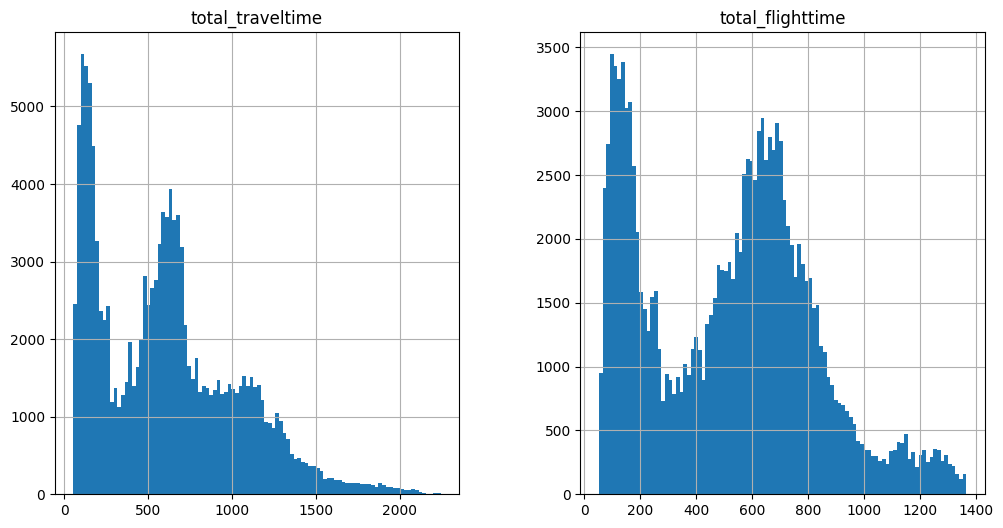

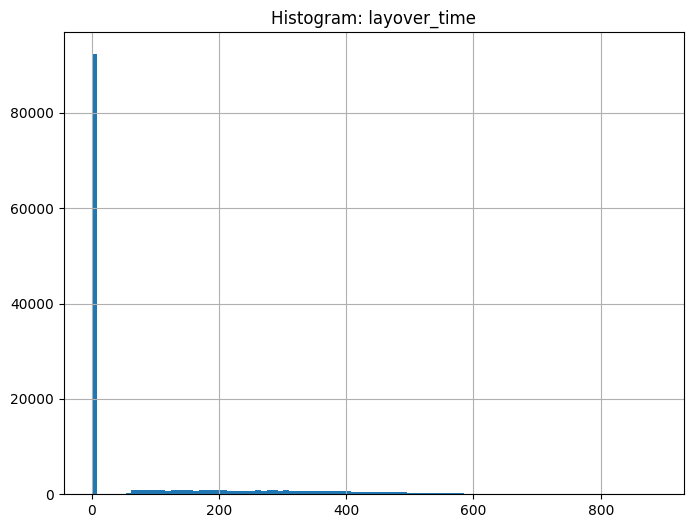

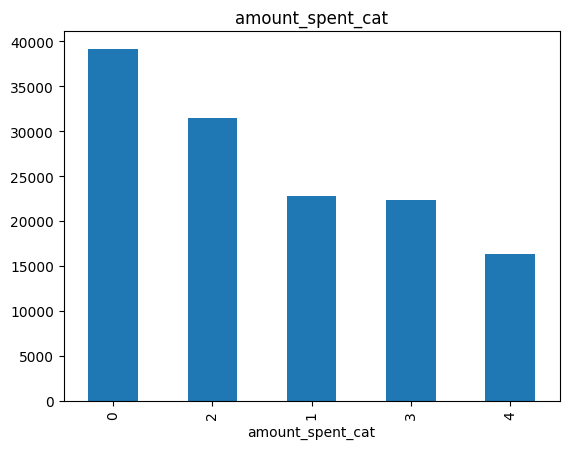

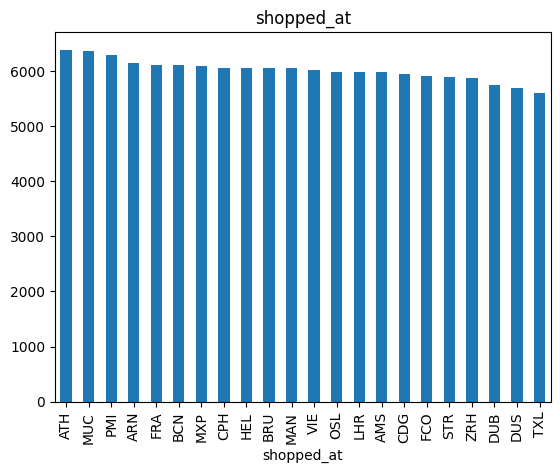

In [40]:
#   Inspect EU passengers table

print("--- EU passengers table (at existing stores in EU) ---")

display("Sample: ", passengers_eu_table.head())

display('Statistics: ', 
        passengers_eu_table.describe(include='all'))

print("Length of data: ", len(passengers_eu_table))

print("Number of duplicates (wrt all columns): ", passengers_eu_table.duplicated().sum())

print("Columns with None values: ", passengers_eu_table.columns[passengers_eu_table.isna().any()].tolist())

print("Percentage of rows with None in departure_IATA_1: ", 
      round(len(passengers_eu_table[passengers_eu_table["departure_IATA_1"].isna()])/len(passengers_eu_table)*100, 2), "%")
print("Percentage of rows with None in destination_IATA_1: ", 
      round(len(passengers_eu_table[passengers_eu_table["destination_IATA_1"].isna()])/len(passengers_eu_table)*100, 2), "%")
print("Percentage of rows with None in departure_IATA_1 or destination_IATA_1: ", 
      round(len(passengers_eu_table[passengers_eu_table["departure_IATA_1"].isna() | passengers_eu_table["destination_IATA_1"].isna()])/len(passengers_eu_table)*100, 2), "%")


print("Number of unique names: ", passengers_eu_table.groupby("name").ngroups)
print("Number of unique (name, birth_date) combinations: ", 
      passengers_eu_table.groupby(['name', "birth_date"]).ngroups)

print("(name, birth_date) combinations occuring multiple times: ")
display(passengers_eu_table.groupby(['name', "birth_date"]).filter(lambda x: len(x) > 1))


print("Distributions: ")

passengers_eu_table[["total_traveltime", "total_flighttime"]].hist(bins=100, figsize=(12, 6), grid=True)
plt.show()

passengers_eu_table["layover_time"].hist(bins=100, figsize=(8, 6), grid=True)
plt.title("Histogram: layover_time")
plt.show()

passengers_eu_table["amount_spent_cat"].value_counts().plot(kind='bar', title="amount_spent_cat")
plt.show()

passengers_eu_table["shopped_at"].value_counts().plot(kind='bar', title="shopped_at")
plt.show()

    

--- WW passengers table (at proposed airports) ---


'Sample: '

,name,sex,birth_date,shopped_at,business_trip,traveled_with_family,luggage,total_flighttime,total_traveltime,layover_time,flight_number_1,departure_IATA_1,destination_IATA_1,flight_number_2,departure_IATA_2,destination_IATA_2
0,Gabriela Schmidlin,f,24/06/1984,HND,yes,no,Brief Case (4L),744.43,744.43,0.0,6U 2572,HND,ADD,NaN,NaN,NaN
1,Kaixin Banacloche,f,31/05/1992,KUL,yes,no,Duffel Bag 12KG,732.68,732.68,0.0,AF 1390,KUL,AMS,NaN,NaN,NaN
2,Manuela Thalberg,f,11/05/1964,HND,yes,no,Duffel Bag 7lbs,523.70,523.70,0.0,SQ 1981,BNE,HND,NaN,NaN,NaN
3,Klaudia Osterhagen,f,17/09/1994,SFO,no,yes,Duffel Bag 16L,876.85,876.85,0.0,IBE 4556,DEL,SFO,NaN,NaN,NaN
4,Cris Caci,f,20/06/1990,JFK,yes,no,Cosmetic Case (3lbs),1077.70,1634.20,556.5,EK 0016,CPT,JFK,QR 8307,JFK,HAV


'Statistics: '

,name,sex,birth_date,shopped_at,business_trip,traveled_with_family,luggage,total_flighttime,total_traveltime,layover_time,flight_number_1,departure_IATA_1,destination_IATA_1,flight_number_2,departure_IATA_2,destination_IATA_2
count,73140,73140,73140,73140,73140,73140,73140,73140.000000,73140.000000,73140.000000,73140,73140,73140,20900,20900,20900
unique,62970,2,18255,12,2,2,2715,NaN,NaN,NaN,19066,192,192,4238,12,192
top,Leon Diederich,f,04/06/1975,HND,no,no,Messenger Bag 5kg,NaN,NaN,NaN,ET 3904,KUL,HND,JL 4312,HND,MEL
freq,7,36734,17,7689,46829,59212,127,NaN,NaN,NaN,18,3477,4789,40,3173,439
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,798.236909,908.836424,110.599515,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,298.915770,444.879724,206.704438,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.170000,51.170000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,602.870000,605.920000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,797.870000,834.530000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1031.250000,1154.030000,131.100000,NaN,NaN,NaN,NaN,NaN,NaN


Length of data:  73140
Columns with None values:  ['flight_number_2', 'departure_IATA_2', 'destination_IATA_2']
Number of duplicates (wrt all columns):  5374
Number of unique names:  62970
Number of unique (name, birth_date) combinations:  67766
Number of unique (name, sex, birth_date) combinations:  67766
Distributions (without duplicates): 


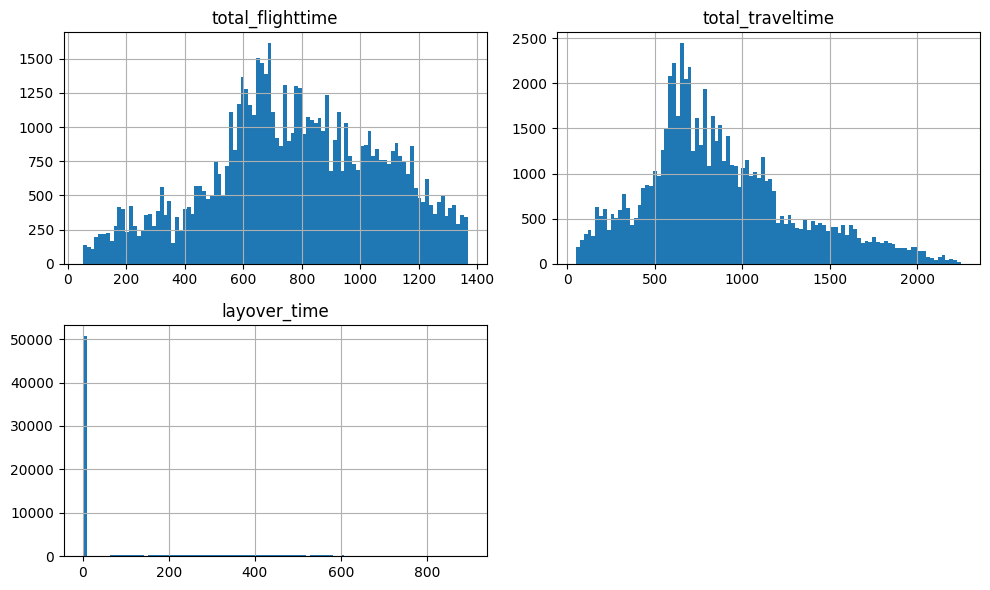

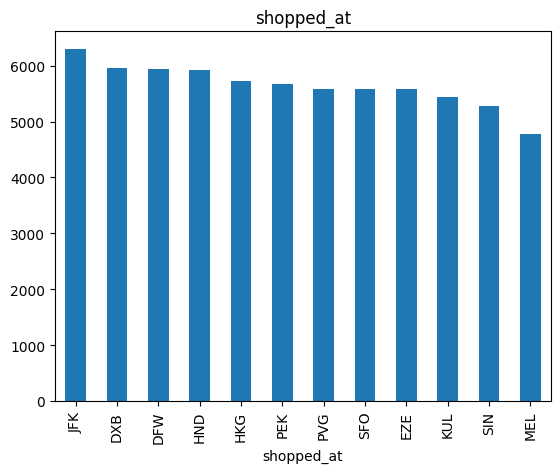

In [41]:
#   Inspect WW passengers table

print("--- WW passengers table (at proposed airports) ---")

display("Sample: ", passengers_ww_table.head())

display('Statistics: ', 
        passengers_ww_table.describe(include='all'))


print("Length of data: ", len(passengers_ww_table))
print("Columns with None values: ", passengers_ww_table.columns[passengers_ww_table.isna().any()].tolist())
print("Number of duplicates (wrt all columns): ", passengers_ww_table.duplicated().sum())

print("Number of unique names: ", passengers_ww_table.groupby("name").ngroups)
print("Number of unique (name, birth_date) combinations: ", 
      passengers_ww_table.groupby(['name', "birth_date"]).ngroups)
print("Number of unique (name, sex, birth_date) combinations: ", 
      passengers_ww_table.groupby(['name', "sex", "birth_date"]).ngroups)


print("Distributions (without duplicates): ")
passengers_ww_table.drop_duplicates().hist(bins=100, figsize=(10, 6), grid=True)
plt.tight_layout()
plt.show()

passengers_ww_table.drop_duplicates()["shopped_at"].value_counts().plot(kind='bar', title="shopped_at")
plt.show()


In [42]:
print("Difference between passengers_eu_table attributes and passengers_ww_table attributes: ")
print(set(passengers_eu_table.columns).difference(set(passengers_ww_table)) )

Difference between passengers_eu_table attributes and passengers_ww_table attributes: 
{'amount_spent_cat'}


### Problem definition and solution approach

Goal: Recommend the best airport location into which to invest

Solution approach: Train a classification model which allows to predict the correct category of amount of expenditure (0, 1, 2, 3, 4) for a given passenger

- Recommended airport = Airport with highest (mean predicted expenditure of passenger)

### Data splitting

In [43]:
#   Splitting

display(f"Available data (shape {passengers_eu_table.shape}): ", passengers_eu_table.head())


X_train, X_test, y_train, y_test = train_test_split(passengers_eu_table.drop(columns="amount_spent_cat"), 
                                                    passengers_eu_table["amount_spent_cat"],
                                                    test_size=0.2, random_state=RANDOM_SEED)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=RANDOM_SEED)

print("Shapes of split data: ")
print("X_train: ", X_train.shape,
      "X_valid: ", X_valid.shape,
      "X_test: ",X_test.shape)

print("y_train: ", y_train.shape, 
      "y_valid: ", y_valid.shape, 
      "y_test: ", y_test.shape)

'Available data (shape (132234, 17)): '

,name,sex,birth_date,shopped_at,business_trip,traveled_with_family,luggage,total_flighttime,total_traveltime,layover_time,amount_spent_cat,flight_number_1,departure_IATA_1,destination_IATA_1,flight_number_2,departure_IATA_2,destination_IATA_2
0,Christian Kluge,m,1977/02/28,BCN,yes,no,Sports Bag 19l,550.48,550.48,0.00,2,LH 5507,BCN,KTM,NaN,NaN,NaN
1,Bernd Jung,m,05/10/1971,MUC,no,no,Bag 19kg,1080.14,1142.62,62.48,4,AXM 2562,HGA,MUC,IBE 1195,MUC,OAK
2,Ralph Dewhirst,m,10/04/1984,HEL,no,no,Duffel Bag [31KG],371.48,371.48,0.00,2,WY 9256,HEL,MCT,NaN,NaN,NaN
3,Jan Egger,m,1973/01/21,VIE,no,no,Bag 16kg,148.88,148.88,0.00,2,MH 8130,VIE,LPL,NaN,NaN,NaN
4,Tom Probst,m,31/03/1985,FRA,yes,no,Bag (5KG),1197.70,1655.78,458.08,3,CA 6749,ZNZ,NaN,DL 7477,NaN,MEX


Shapes of split data: 
X_train:  (84629, 16) X_valid:  (21158, 16) X_test:  (26447, 16)
y_train:  (84629,) y_valid:  (21158,) y_test:  (26447,)


### Data preprocessing

In [44]:
#   Drop certain rows and columns

"""
#   Not dropping; reason: Passenger has different features for two flights; could benefit for training

#   Drop people occuring multiple times w.r.t. "name", "sex", "birth_date" -> "Luca Herz", "m", "06/02/1973" occurs 2 times
print(len(passengers_eu_table))

passengers_eu_table = passengers_eu_table[~passengers_eu_table.duplicated(subset=['name', 'sex', 'birth_date'], keep=False)]

print(len(passengers_eu_table))

"""

def drop_unused_cols(data: pd.DataFrame, is_eu_data: bool):

    unused_cols = ["name", # ID-related
                   "flight_number_1", "flight_number_2",
                   "total_traveltime", # since "total_flighttime" and "layover_time" used
                   "departure_IATA_1", "destination_IATA_1", "departure_IATA_2", "destination_IATA_2"
                   ]
    
    if is_eu_data:
        unused_cols.append("shopped_at")    #   Drop for EU data; keep for applying to WW data

    return data.drop(columns=unused_cols)


In [45]:
#     Create "luggage_type" and "luggage_weight_or_size" from luggage column

print("Same unique luggages in EU dataset and WW dataset? ", 
      len(set(passengers_eu_table['luggage']).difference(passengers_ww_table['luggage'])) == 0)


def create_luggage_features(data: pd.DataFrame):

      #temp_eu = passengers_eu_table['luggage'].str.extract(r'(\w+\s\w*)(?=.*\d)')
      #print(temp_eu.value_counts())


      luggage_types = ["Bag", "Messenger Bag", "Duffel Bag", "Cosmetic Case", "Purse", 
                  "Brief Case", "Backpack", "Trolley", "Suitcase", "Sports Bag"]

      luggage_type_pattern = '|'.join(luggage_types)

      data["luggage_type"] = data['luggage'].str.extract(f'^({luggage_type_pattern})')

      #print('Unique "luggage_type" values (including potential None): ', 
      #      data["luggage_type"].value_counts(dropna=False).keys())


      ####################################################################################################################

      luggage_weight_or_size_with_unit = data['luggage'].str.extract(r'(\d+\w*)', expand=False)

      #print(luggage_weight_or_size_with_unit[0:10])


      weight_or_size_types = ["l", "L", "kg", "KG", "lbs"]
      weight_or_size_pattern = r'(' + '|'.join(weight_or_size_types) + r')$'
      

      luggage_weight_or_size = luggage_weight_or_size_with_unit.str.replace(weight_or_size_pattern, '', 
                                                                                    regex=True).astype(float)
      
      luggage_unit = luggage_weight_or_size_with_unit.str.extract(weight_or_size_pattern, expand=False)

      #     lbs values to kg ; then map 'lbs' to 'kg' and make two units 'l', 'kg'

      lbs_to_kg_factor = 0.45359237


      data["luggage_weight_or_size"] = np.where(luggage_unit == 'lbs',
                                                luggage_weight_or_size * lbs_to_kg_factor,
                                                luggage_weight_or_size)
      
      #     Binning into intervals (right edge included)
      data["luggage_weight_or_size"] = np.ceil(data["luggage_weight_or_size"])


      #print(data["luggage_weight_or_size"][0:10])

      luggage_unit_corrected = np.where(luggage_unit.isin(['lbs', 'kg', 'KG']),
                                        'kg', 
                                        luggage_unit)
      
      data["luggage_unit"] = np.where(np.isin(luggage_unit_corrected, ["l", "L"]),
                                      "l", 
                                      luggage_unit_corrected)

      #print(data["luggage_unit"][0:10])

      #print("Unique luggage_weight_or_size values (including potential None): ", 
      #      data["luggage_weight_or_size"].value_counts(dropna=False).keys())


      #data["luggage_weight_or_size"].value_counts().plot(kind='bar', title="luggage_weight_or_size")
      #plt.show()

      #     Not used for model training
      data = data.drop(columns=["luggage"])

      return data


Same unique luggages in EU dataset and WW dataset?  True


In [46]:
#     Create "age_category" column from birth_date column

def create_age_feature(data: pd.DataFrame):

    age_column = 2019 - pd.to_datetime(data["birth_date"], format='mixed').dt.year

    data["age_category"] = pd.cut(age_column, 
                            bins=[0, 17, 21, 25, 30, 35, 40, 50, 60, 70, 80, np.inf], 
                            right=True,
                            labels=False)


    #   Drop birth_day column (age_category used)
    data = data.drop(columns=["birth_date"])

    return data


In [47]:
#   Feature Encoding

def encode_cat_columns(data: pd.DataFrame):

    cols_to_encode = ["sex", 
                      "business_trip", 
                      "traveled_with_family", 
                      "luggage_type", 
                      "luggage_unit",]

    data = pd.get_dummies(data=data, columns=cols_to_encode)

    return data


In [48]:
#   Transformation pipe

def transform_feature_data(data: pd.DataFrame, is_eu_data: bool):
    data = drop_unused_cols(data, is_eu_data=is_eu_data)
    data = create_luggage_features(data=data)
    data = create_age_feature(data=data)
    data = encode_cat_columns(data)

    return data


In [49]:
#   Transform X_train, X_test and X_valid

X_train = transform_feature_data(X_train, is_eu_data=True)

X_test = transform_feature_data(X_test, is_eu_data=True)

X_valid = transform_feature_data(X_valid, is_eu_data=True)

#   Check
if set(X_train.columns) != set(X_test.columns) or set(X_valid.columns) != set(X_test.columns):
    raise Exception("Column mismatch")

print("Attributes for training/testing: ", X_train.columns)

Attributes for training/testing:  Index(['total_flighttime', 'layover_time', 'luggage_weight_or_size',
       'age_category', 'sex_f', 'sex_m', 'business_trip_no',
       'business_trip_yes', 'traveled_with_family_no',
       'traveled_with_family_yes', 'luggage_type_Backpack', 'luggage_type_Bag',
       'luggage_type_Brief Case', 'luggage_type_Cosmetic Case',
       'luggage_type_Duffel Bag', 'luggage_type_Messenger Bag',
       'luggage_type_Purse', 'luggage_type_Sports Bag',
       'luggage_type_Suitcase', 'luggage_type_Trolley', 'luggage_unit_kg',
       'luggage_unit_l'],
      dtype='object')


### Model building and training

In [50]:
#   Model training

MODEL_TYPE = 'neural_net'


class NeuralNetwork(nn.Module):
    def __init__(self, input_size: int, hidden_size_1: int, hidden_size_2: int, hidden_size_3: int, 
                 num_classes: int):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size_1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.fc3 = nn.Linear(hidden_size_2, hidden_size_3)
        self.fc4 = nn.Linear(hidden_size_3, num_classes)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc4(out)
        return out

def fit_neural_network(X_train: pd.DataFrame, y_train: pd.Series, 
                       X_valid: pd.DataFrame, y_valid: pd.Series):

    X_train_tensor = torch.tensor(X_train.astype(np.float32).values, 
                                  dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)

    X_valid_tensor = torch.tensor(X_valid.astype(np.float32).values, 
                                  dtype=torch.float32)
    y_valid_tensor = torch.tensor(y_valid.values, dtype=torch.long)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)

    model_params = {
        "input_size": len(X_train.columns),
        "hidden_size_1": 128,
        "hidden_size_2": 256,
        "hidden_size_3": 128,
        "num_classes": 5,
    }

    model = NeuralNetwork(**model_params)

    learning_rate = 0.001
    num_epochs = 50
    batch_size = 64

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Create DataLoader

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(valid_dataset, batch_size=batch_size)

    num_batches_train = len(train_loader)
    num_batches_val = len(val_loader)

    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        train_loss = 0.0
        val_loss = 0.0
        
        # Train
        model.train()
        for _, (batch_data, batch_labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(batch_data)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Valid
        model.eval()
        with torch.no_grad():
            for batch_data, batch_labels in val_loader:
                outputs = model(batch_data)
                loss = criterion(outputs, batch_labels)
                val_loss += loss.item()
        
        # Average losses
        avg_train_loss = train_loss / num_batches_train
        avg_val_loss = val_loss / num_batches_val
        
        # Print epoch information
        print('Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}'
            .format(epoch+1, num_epochs, avg_train_loss, avg_val_loss))
        
        #   Save model state if best epoch
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_model.pth')
    
    return model


def fit_xgb_classifier(X_train: pd.DataFrame, y_train: pd.Series, 
                       X_valid: pd.DataFrame, y_valid: pd.Series):
    
    params = {
        'objective': 'multi:softmax',  # objective is softmax loss
        'num_class': 5,
        'max_depth': 9,
        'eta': 0.02,  # lr
    }

    num_rounds = 1000

    #   DMatrix format -> optimized data structure

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_valid, label=y_valid)

    evals = [(dval, 'validation_set')]

    #   XGB classifier used 

    model = xgb.train(params=params, 
                    dtrain=dtrain, 
                    num_boost_round=num_rounds,
                    evals=evals,
                    early_stopping_rounds=20)    

    return model


if MODEL_TYPE == 'xgb':
    model = fit_xgb_classifier(X_train=X_train, y_train=y_train, X_valid=X_valid, y_valid=y_valid)
elif MODEL_TYPE == 'neural_net':
    model = fit_neural_network(X_train=X_train, y_train=y_train, X_valid=X_valid, y_valid=y_valid)
else:
    raise Exception("Invalid MODEL_TYPE")



Epoch [1/50], Train Loss: 1.0356, Val Loss: 0.8579
Epoch [2/50], Train Loss: 0.7856, Val Loss: 0.7375
Epoch [3/50], Train Loss: 0.6931, Val Loss: 0.7437
Epoch [4/50], Train Loss: 0.6635, Val Loss: 0.6581
Epoch [5/50], Train Loss: 0.6369, Val Loss: 0.5993
Epoch [6/50], Train Loss: 0.6188, Val Loss: 0.6157
Epoch [7/50], Train Loss: 0.6010, Val Loss: 0.5695
Epoch [8/50], Train Loss: 0.5902, Val Loss: 0.6010
Epoch [9/50], Train Loss: 0.5854, Val Loss: 0.5660
Epoch [10/50], Train Loss: 0.5781, Val Loss: 0.5522
Epoch [11/50], Train Loss: 0.5732, Val Loss: 0.5578
Epoch [12/50], Train Loss: 0.5674, Val Loss: 0.5515
Epoch [13/50], Train Loss: 0.5637, Val Loss: 0.5642
Epoch [14/50], Train Loss: 0.5675, Val Loss: 0.5538
Epoch [15/50], Train Loss: 0.5600, Val Loss: 0.5438
Epoch [16/50], Train Loss: 0.5563, Val Loss: 0.5594
Epoch [17/50], Train Loss: 0.5579, Val Loss: 0.5631
Epoch [18/50], Train Loss: 0.5560, Val Loss: 0.5423
Epoch [19/50], Train Loss: 0.5499, Val Loss: 0.5295
Epoch [20/50], Train 

In [51]:
#   Feature importance

#   F-score used as importance metric -> number of times a feature is used to split the data across all trees

if MODEL_TYPE == 'xgb':
    fig, ax = plt.subplots(figsize=(12, 8), dpi=300)
    xgb.plot_importance(model, 
                        max_num_features=10, 
                        title="Feature importance (Top 10 most important)",
                        grid=False, 
                        ax=ax)
    plt.show()


### Evaluation of model on EU test data

Classification statistics: 
               precision    recall  f1-score   support

           0     0.8548    0.6627    0.7466      7897
           1     0.6218    0.6851    0.6519      4496
           2     0.6426    0.8149    0.7186      6289
           3     0.8547    0.8241    0.8391      4525
           4     0.8922    0.8355    0.8629      3240

    accuracy                         0.7515     26447
   macro avg     0.7732    0.7644    0.7638     26447
weighted avg     0.7693    0.7515    0.7539     26447



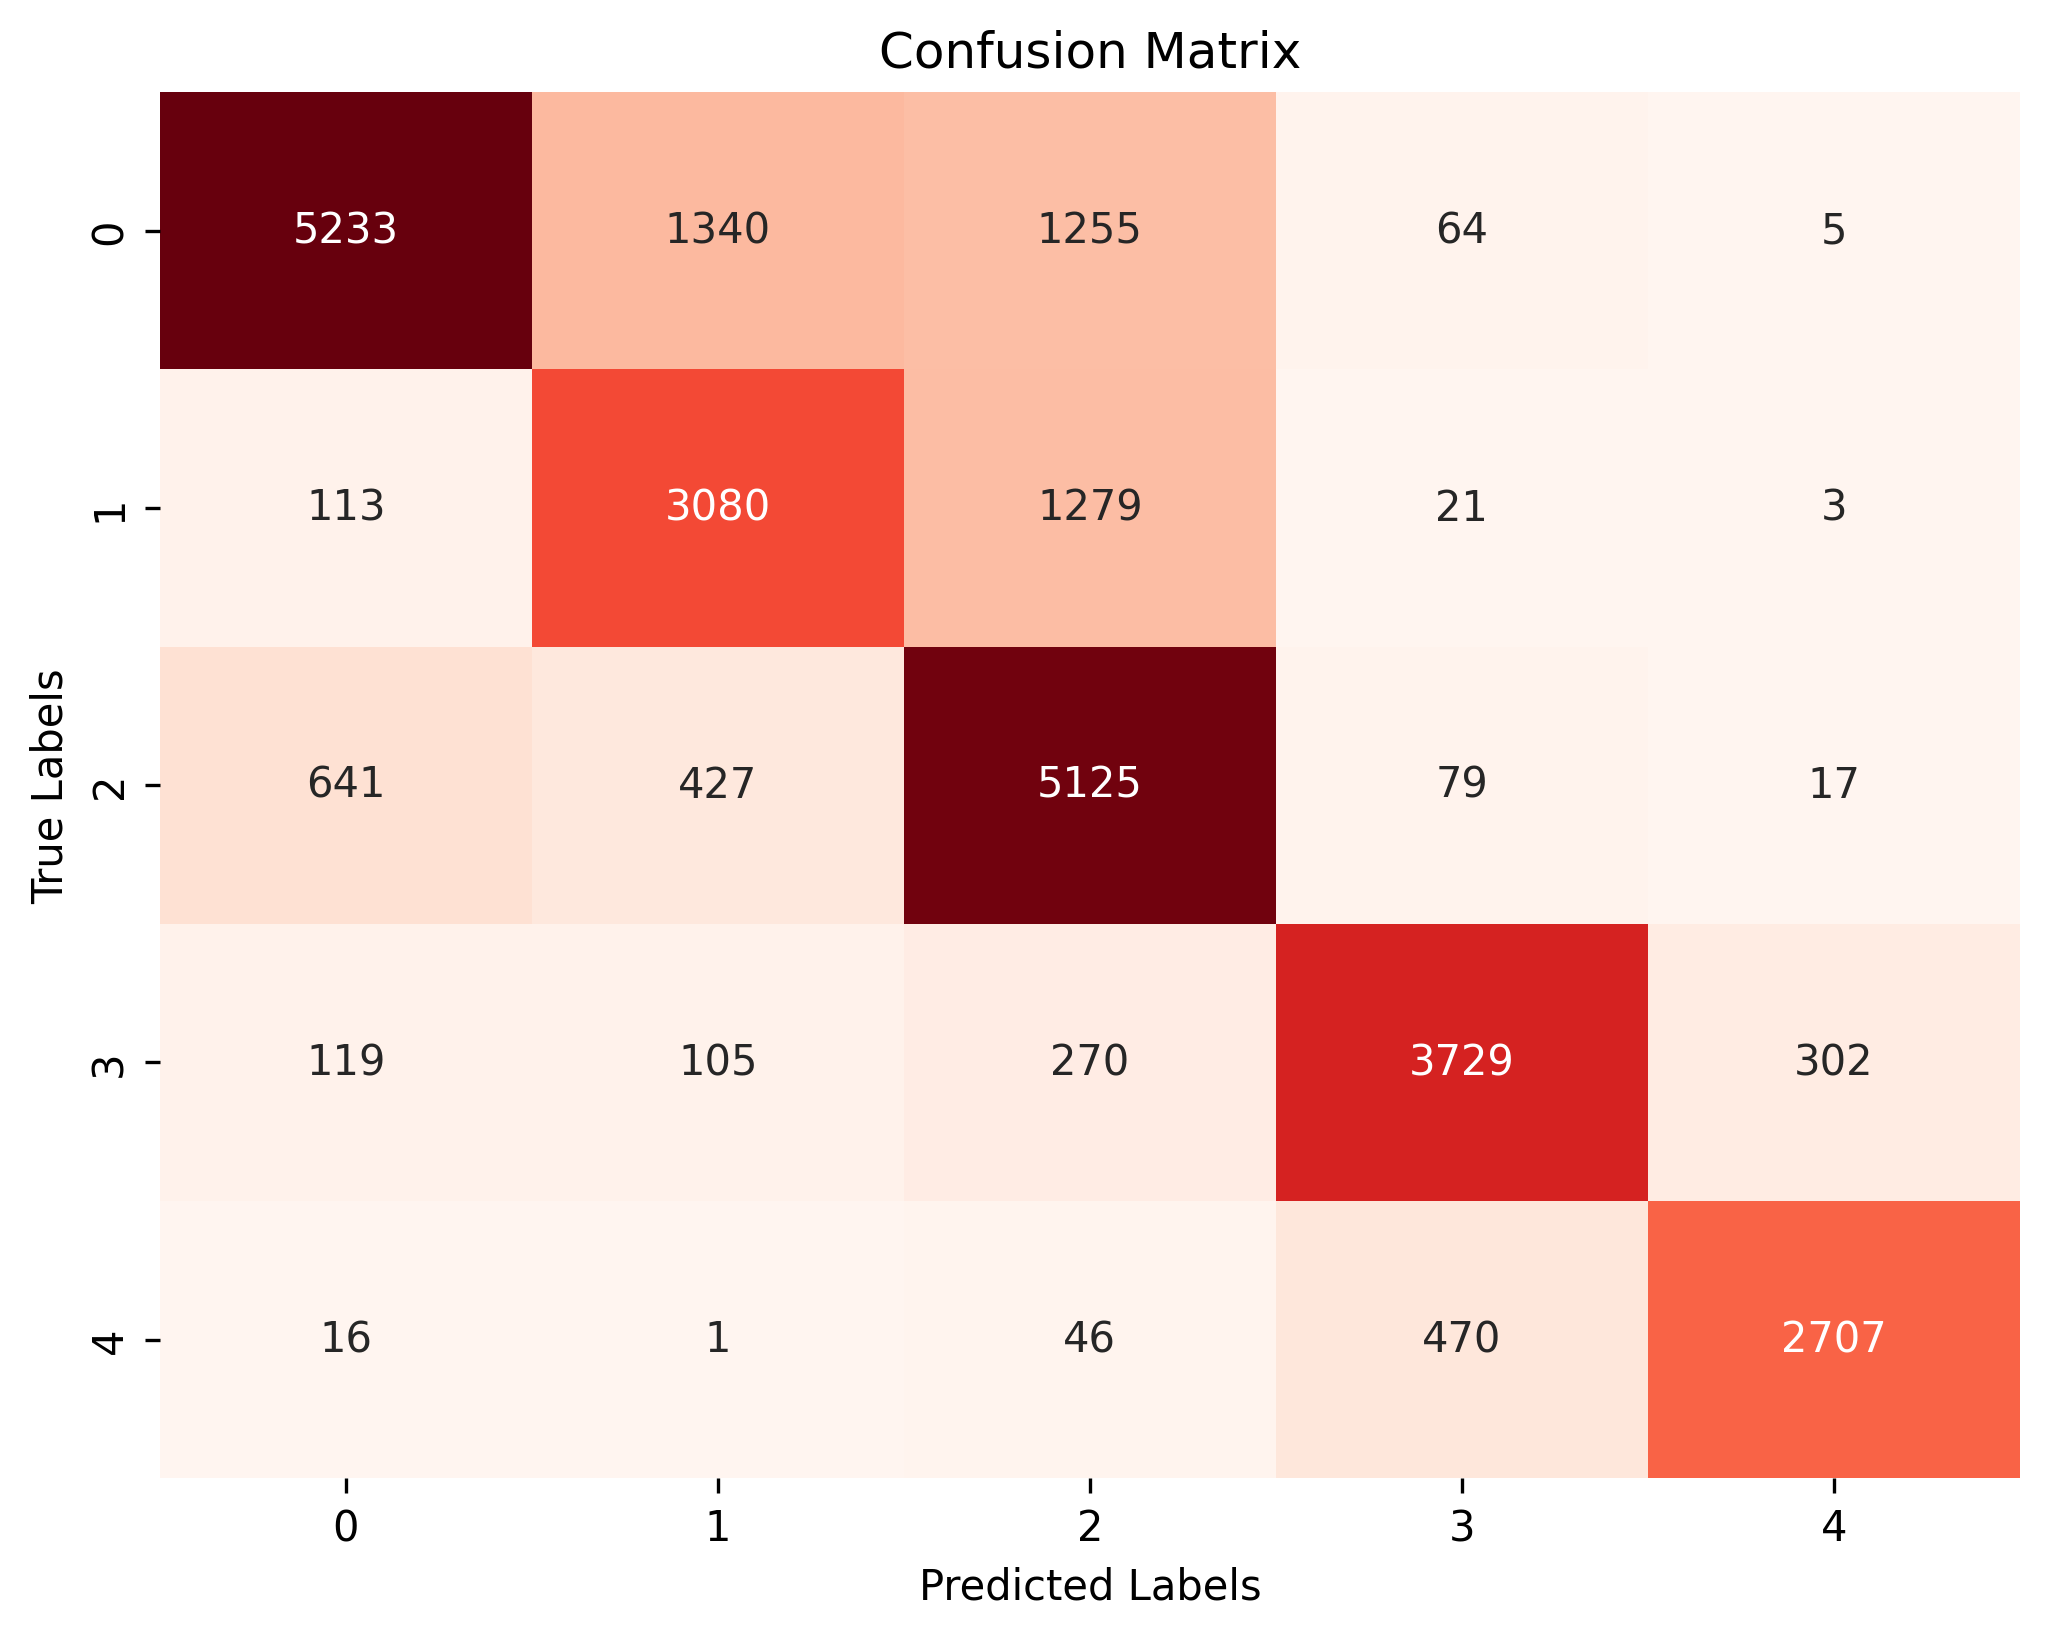

In [52]:
#   Evaluation


#   Make predictions on the testing data

if MODEL_TYPE == 'neural_net':
    X_train_tensor = torch.tensor(X_test.astype(np.float32).values, 
                                  dtype=torch.float32)
    
    #   Load best epoch wrt. valid loss
    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()
    
    predictions = model(X_train_tensor).detach().numpy()

    predictions = np.argmax(predictions, axis=-1)
    
elif MODEL_TYPE == 'xgb':
    dtest = xgb.DMatrix(X_test, label=y_test)
    predictions = model.predict(dtest)



# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)

#   Using macro average => compute metric independently for each class and then take the mean

precision_scores = precision_score(y_test, predictions, average=None)
precision_avg = precision_score(y_test, predictions, average="macro")

recall_scores = recall_score(y_test, predictions, average=None)
recall_avg = recall_score(y_test, predictions, average="macro")

report = classification_report(y_test, predictions, digits=4)

conf_matrix = confusion_matrix(y_true=y_test, y_pred=predictions)

print("Classification statistics: \n", report)

# Plot confusion matrix
plt.figure(figsize=(8, 6), dpi=300)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Reds", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


### Predictions for WW data

In [53]:
#   Drop duplicates in WW data

print("Length of WW table (before)", len(passengers_ww_table))

passengers_ww_table.drop_duplicates(inplace=True)

print("Length of WW table (after)", len(passengers_ww_table))

print("WW data has unique rows wrt name and birth_day? ", 
      passengers_ww_table.groupby(['name', "birth_date"]).ngroups == len(passengers_ww_table))


Length of WW table (before) 73140
Length of WW table (after) 67766
WW data has unique rows wrt name and birth_day?  True


In [54]:
#   Apply features preprocessing required for model

passengers_ww_table = transform_feature_data(data=passengers_ww_table, 
                                             is_eu_data=False)


#   Drop shopped_at column to get model predictions

ww_table_to_predict = passengers_ww_table.drop(columns=["shopped_at"])



pred_amount_spent_cat
2    17981
3    15598
0    15073
1    10157
4     8957
Name: count, dtype: int64


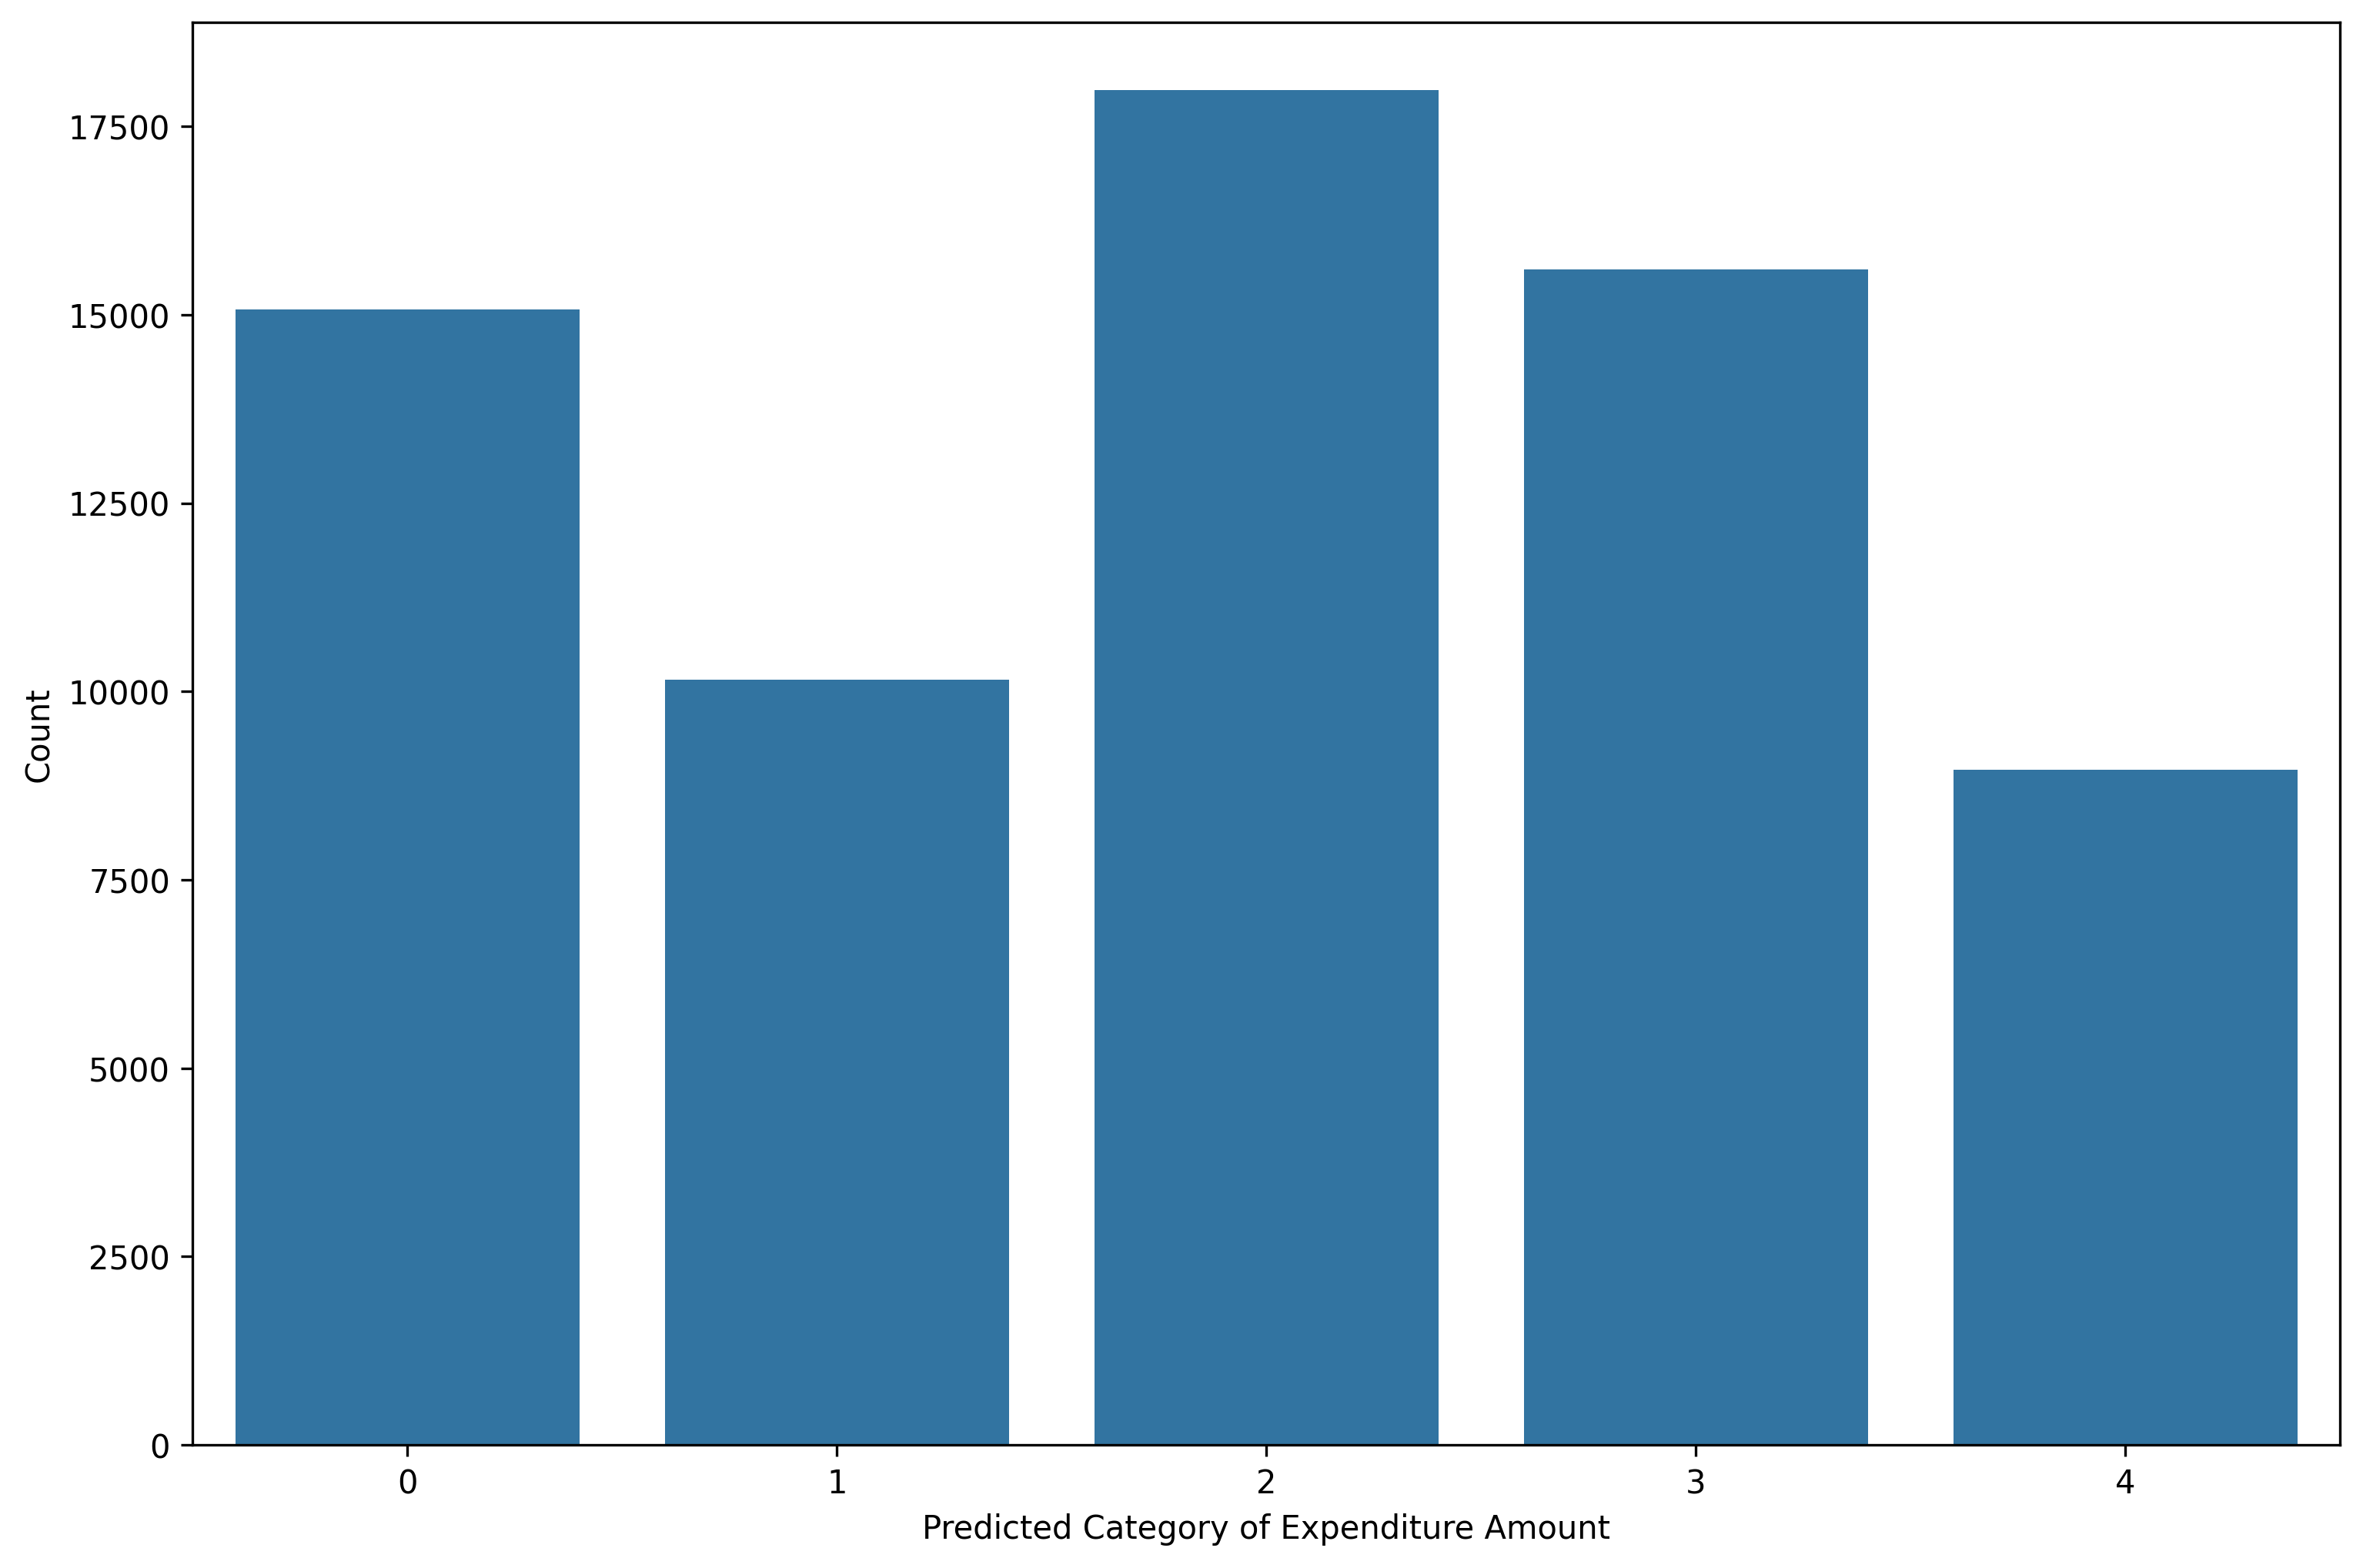

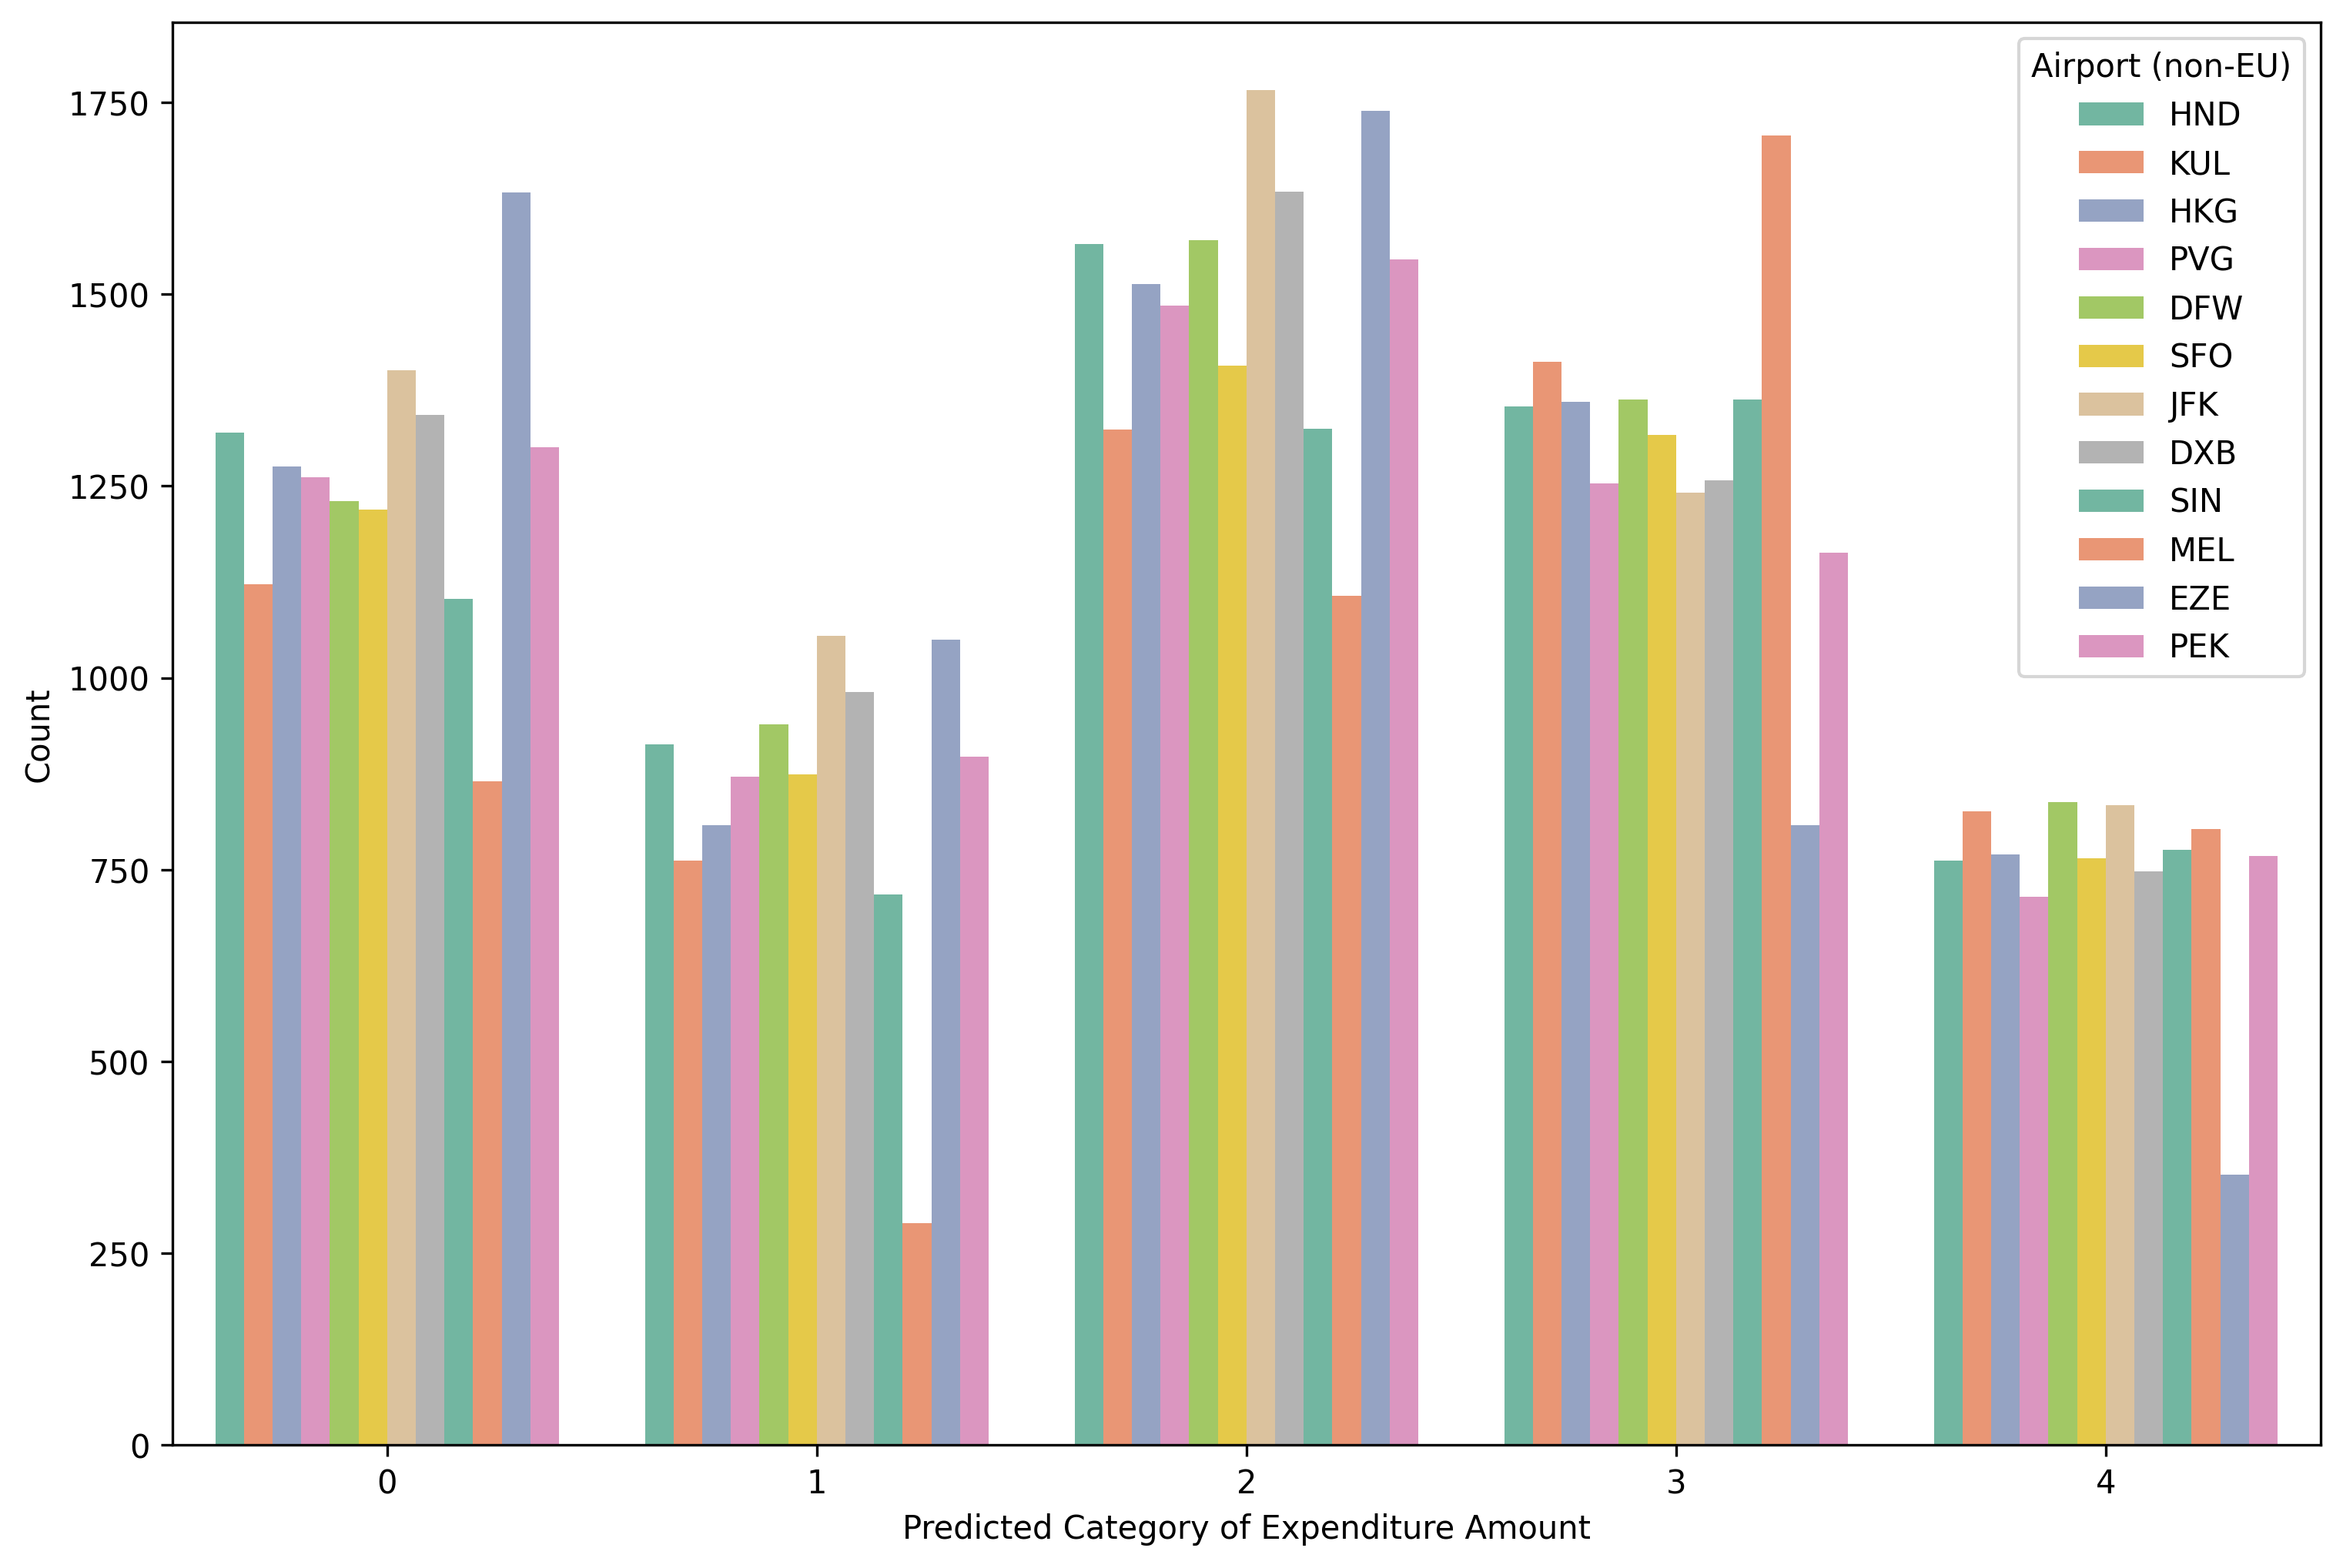

,shopped_at,count_all,sum_amount_spent_cat_per_airport,mean_amount_spent_cat_per_airport,std_amount_spent_cat_per_airport,median_amount_spent_cat_per_airport
0,DFW,5941,11522,1.939404,1.332840,2.0
1,DXB,5963,11012,1.846721,1.324675,2.0
2,EZE,5582,8360,1.497671,1.226059,2.0
3,HKG,5726,10994,1.920014,1.342055,2.0
4,HND,5914,11153,1.885864,1.333711,2.0
5,JFK,6297,11646,1.849452,1.327387,2.0
6,KUL,5446,10950,2.010650,1.352845,2.0
7,MEL,4771,10836,2.271222,1.320460,3.0
8,PEK,5674,10548,1.859006,1.342416,2.0
9,PVG,5585,10460,1.872874,1.334047,2.0


/var/folders/h7/h94plnfj6nqb6dcsb033zwp00000gn/T/ipykernel_288/857374146.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=stats_per_airport_sorted_by_mean,


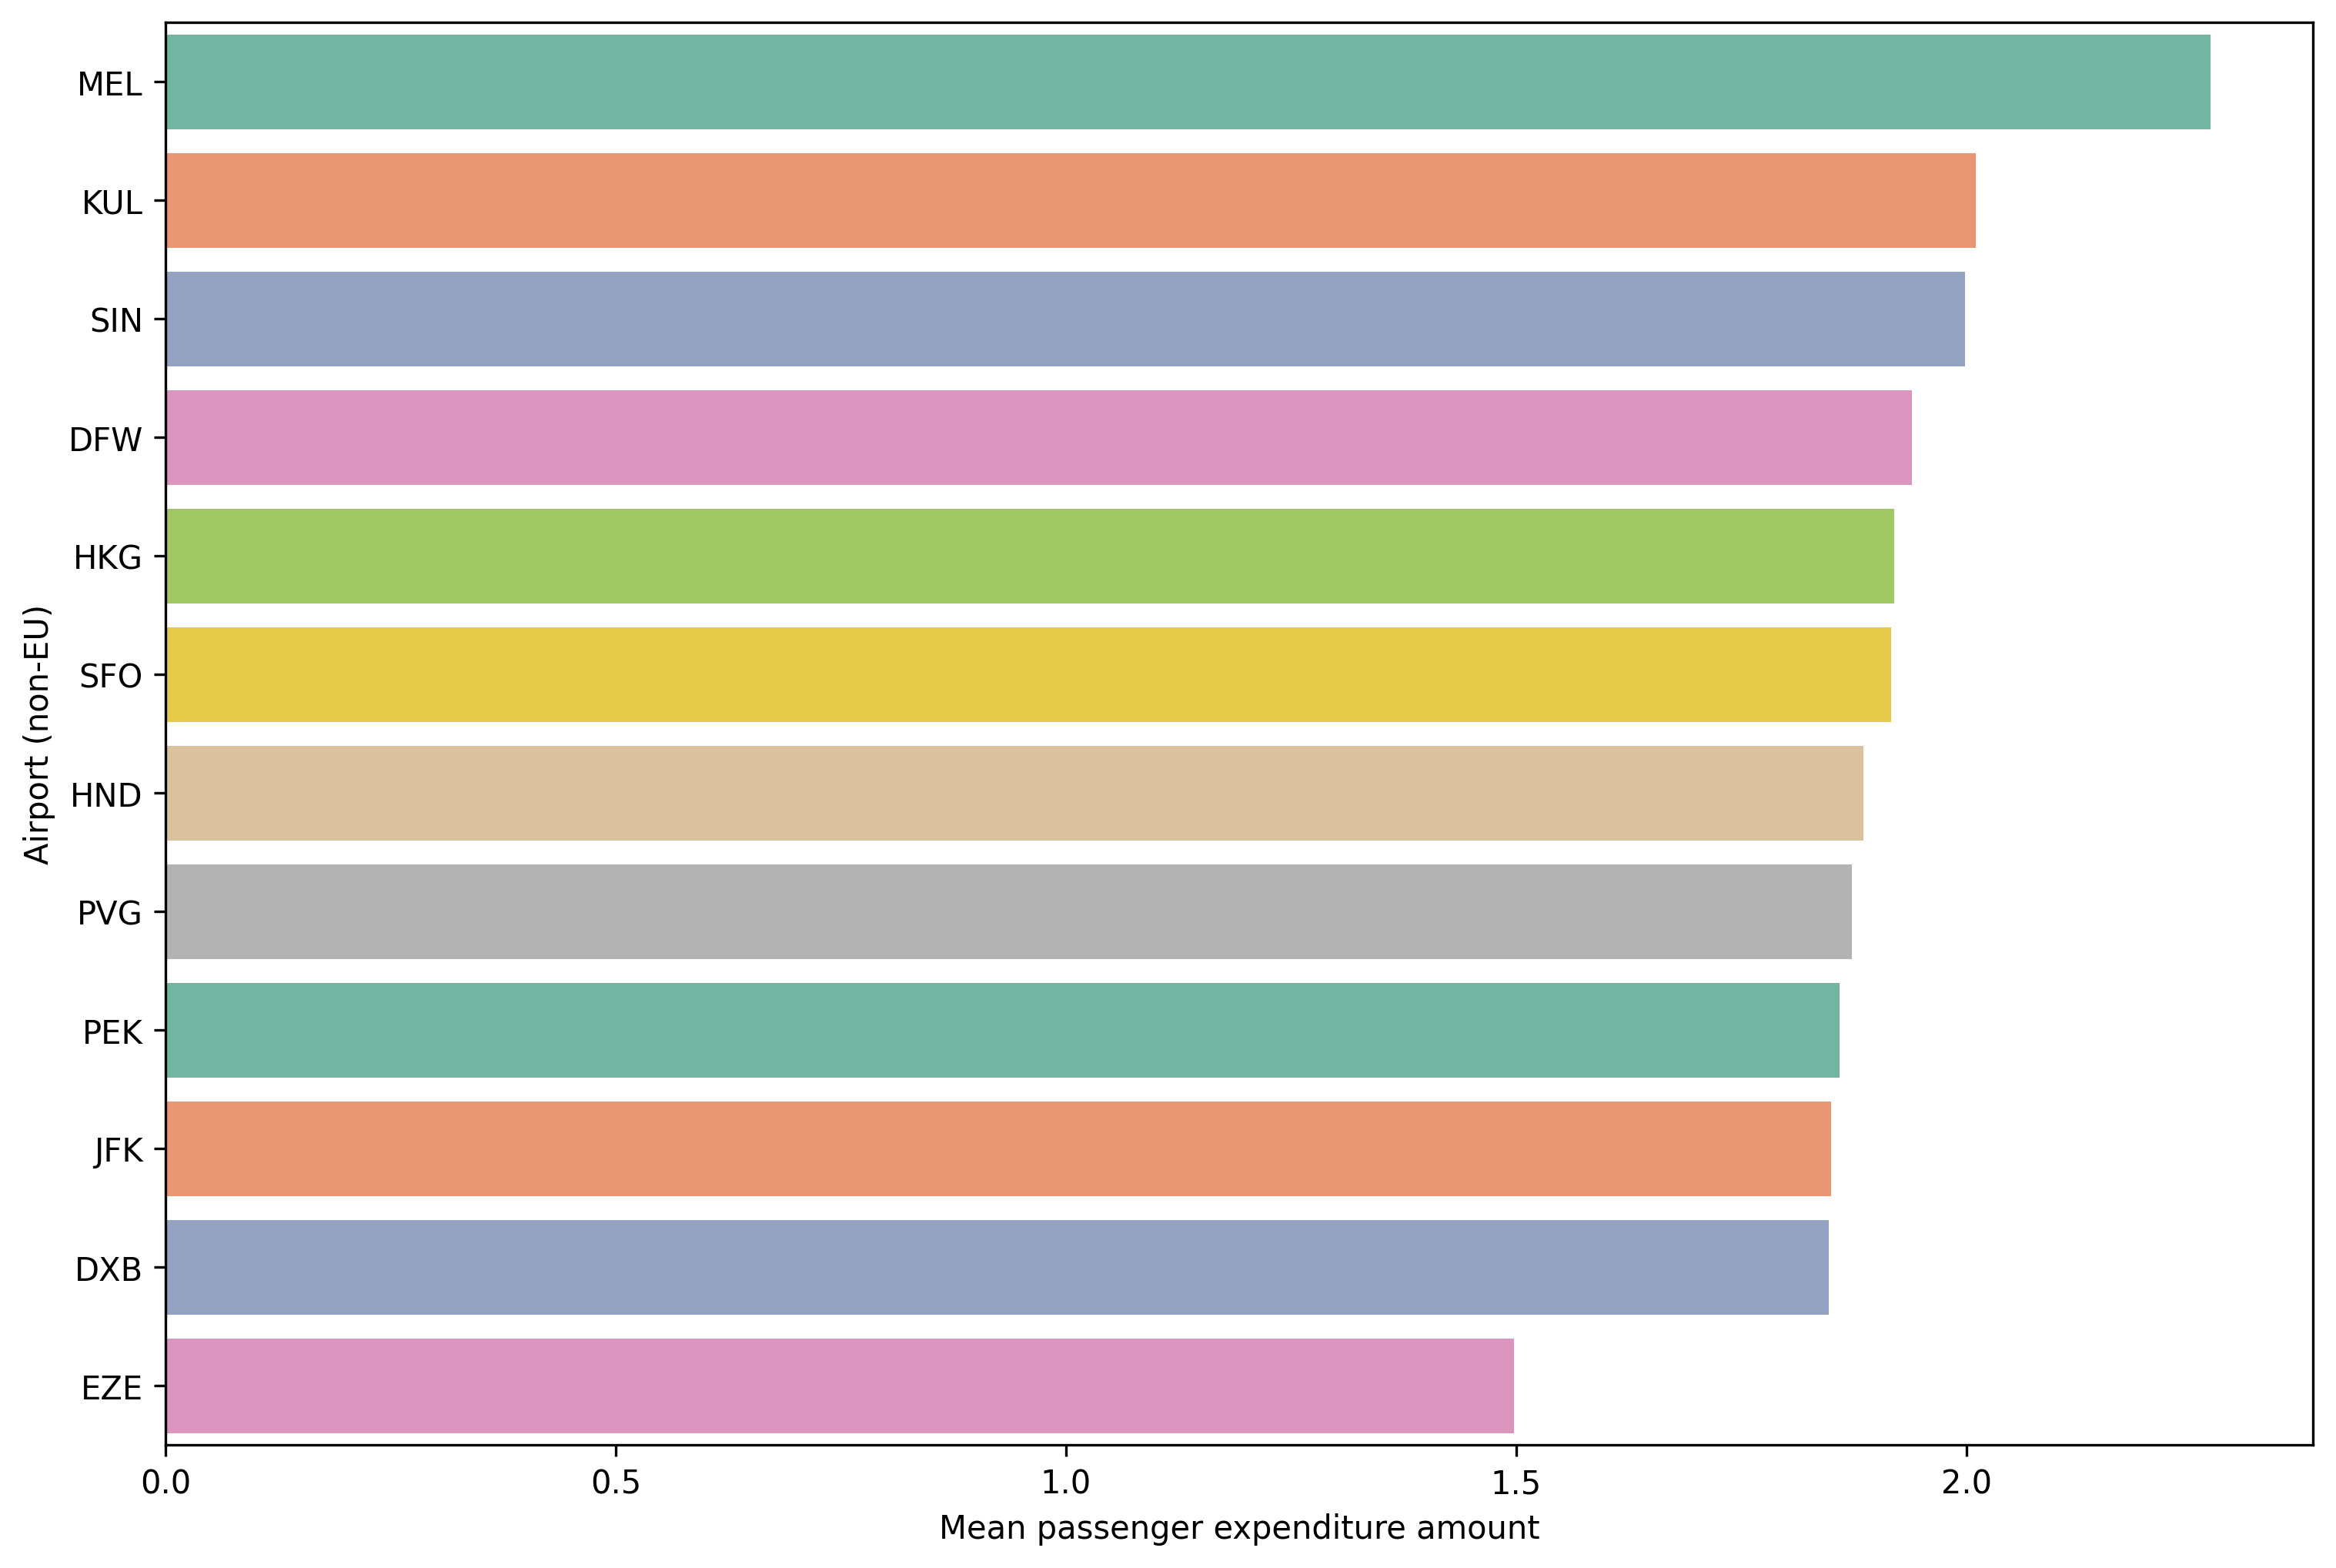

In [55]:
#   Get predictions for WW data passengers 

if MODEL_TYPE == 'xgb':
    ww_table_to_predict_matrix = xgb.DMatrix(ww_table_to_predict)

    passengers_ww_table["pred_amount_spent_cat"] = model.predict(ww_table_to_predict_matrix)
elif MODEL_TYPE == 'neural_net':
    
    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()

    ww_table_to_predict_tensor = torch.tensor(ww_table_to_predict.astype(np.float32).values, 
                                  dtype=torch.float32)
    
    preds_ww = model(ww_table_to_predict_tensor).detach().numpy()

    passengers_ww_table["pred_amount_spent_cat"] = np.argmax(preds_ww, axis=-1)



print(passengers_ww_table["pred_amount_spent_cat"].value_counts(dropna=False))


#   Visualizations for predictions

plt.figure(figsize=(12, 8), dpi=300)
sns.countplot(data=passengers_ww_table, x='pred_amount_spent_cat')
plt.title('')
plt.xlabel('Predicted Category of Expenditure Amount')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(12, 8), dpi=300)
sns.countplot(data=passengers_ww_table, x='pred_amount_spent_cat', hue='shopped_at', palette='Set2')
plt.title('')
plt.xlabel('Predicted Category of Expenditure Amount')
plt.ylabel('Count')
plt.legend(title='Airport (non-EU)')
plt.show()


#   Aggregations (mean, std, median) pred_amount_spent_cat per airport

groupby_airport = passengers_ww_table.groupby('shopped_at')


agg_args = {
    "count_all": ('pred_amount_spent_cat', 'size'),
    'sum_amount_spent_cat_per_airport': ('pred_amount_spent_cat', 'sum'),
    'mean_amount_spent_cat_per_airport': ('pred_amount_spent_cat', 'mean'),
    'std_amount_spent_cat_per_airport': ('pred_amount_spent_cat', 'std'),
    'median_amount_spent_cat_per_airport': ('pred_amount_spent_cat', 'median'),
}

stats_per_airport = groupby_airport.agg(**agg_args).reset_index()

display(stats_per_airport)

stats_per_airport_sorted_by_mean = stats_per_airport.sort_values(by='mean_amount_spent_cat_per_airport', 
                                                                 ascending=False)

plt.figure(figsize=(12, 8), dpi=300)
sns.barplot(data=stats_per_airport_sorted_by_mean, 
            x='mean_amount_spent_cat_per_airport',
            y='shopped_at', 
            palette='Set2')
plt.title('')
plt.xlabel('Mean passenger expenditure amount')
plt.ylabel('Airport (non-EU)')
plt.show()



### Consideration of store leasing expenditures

,Airport,sqm of store,price per sqm/month,leasing_price_per_month
0,DFW,42,21,882.0
1,DXB,151,23,3473.0
2,EZE,276,23,6348.0
3,HKG,150,28,4200.0
4,HND,117,23,2691.0
5,JFK,97,27,2619.0
6,KUL,119,19,2261.0
7,MEL,207,27,5589.0
8,PEK,89,17,1513.0
9,PVG,59,19,1121.0


/var/folders/h7/h94plnfj6nqb6dcsb033zwp00000gn/T/ipykernel_288/439069285.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=airports_tol_table_sorted,


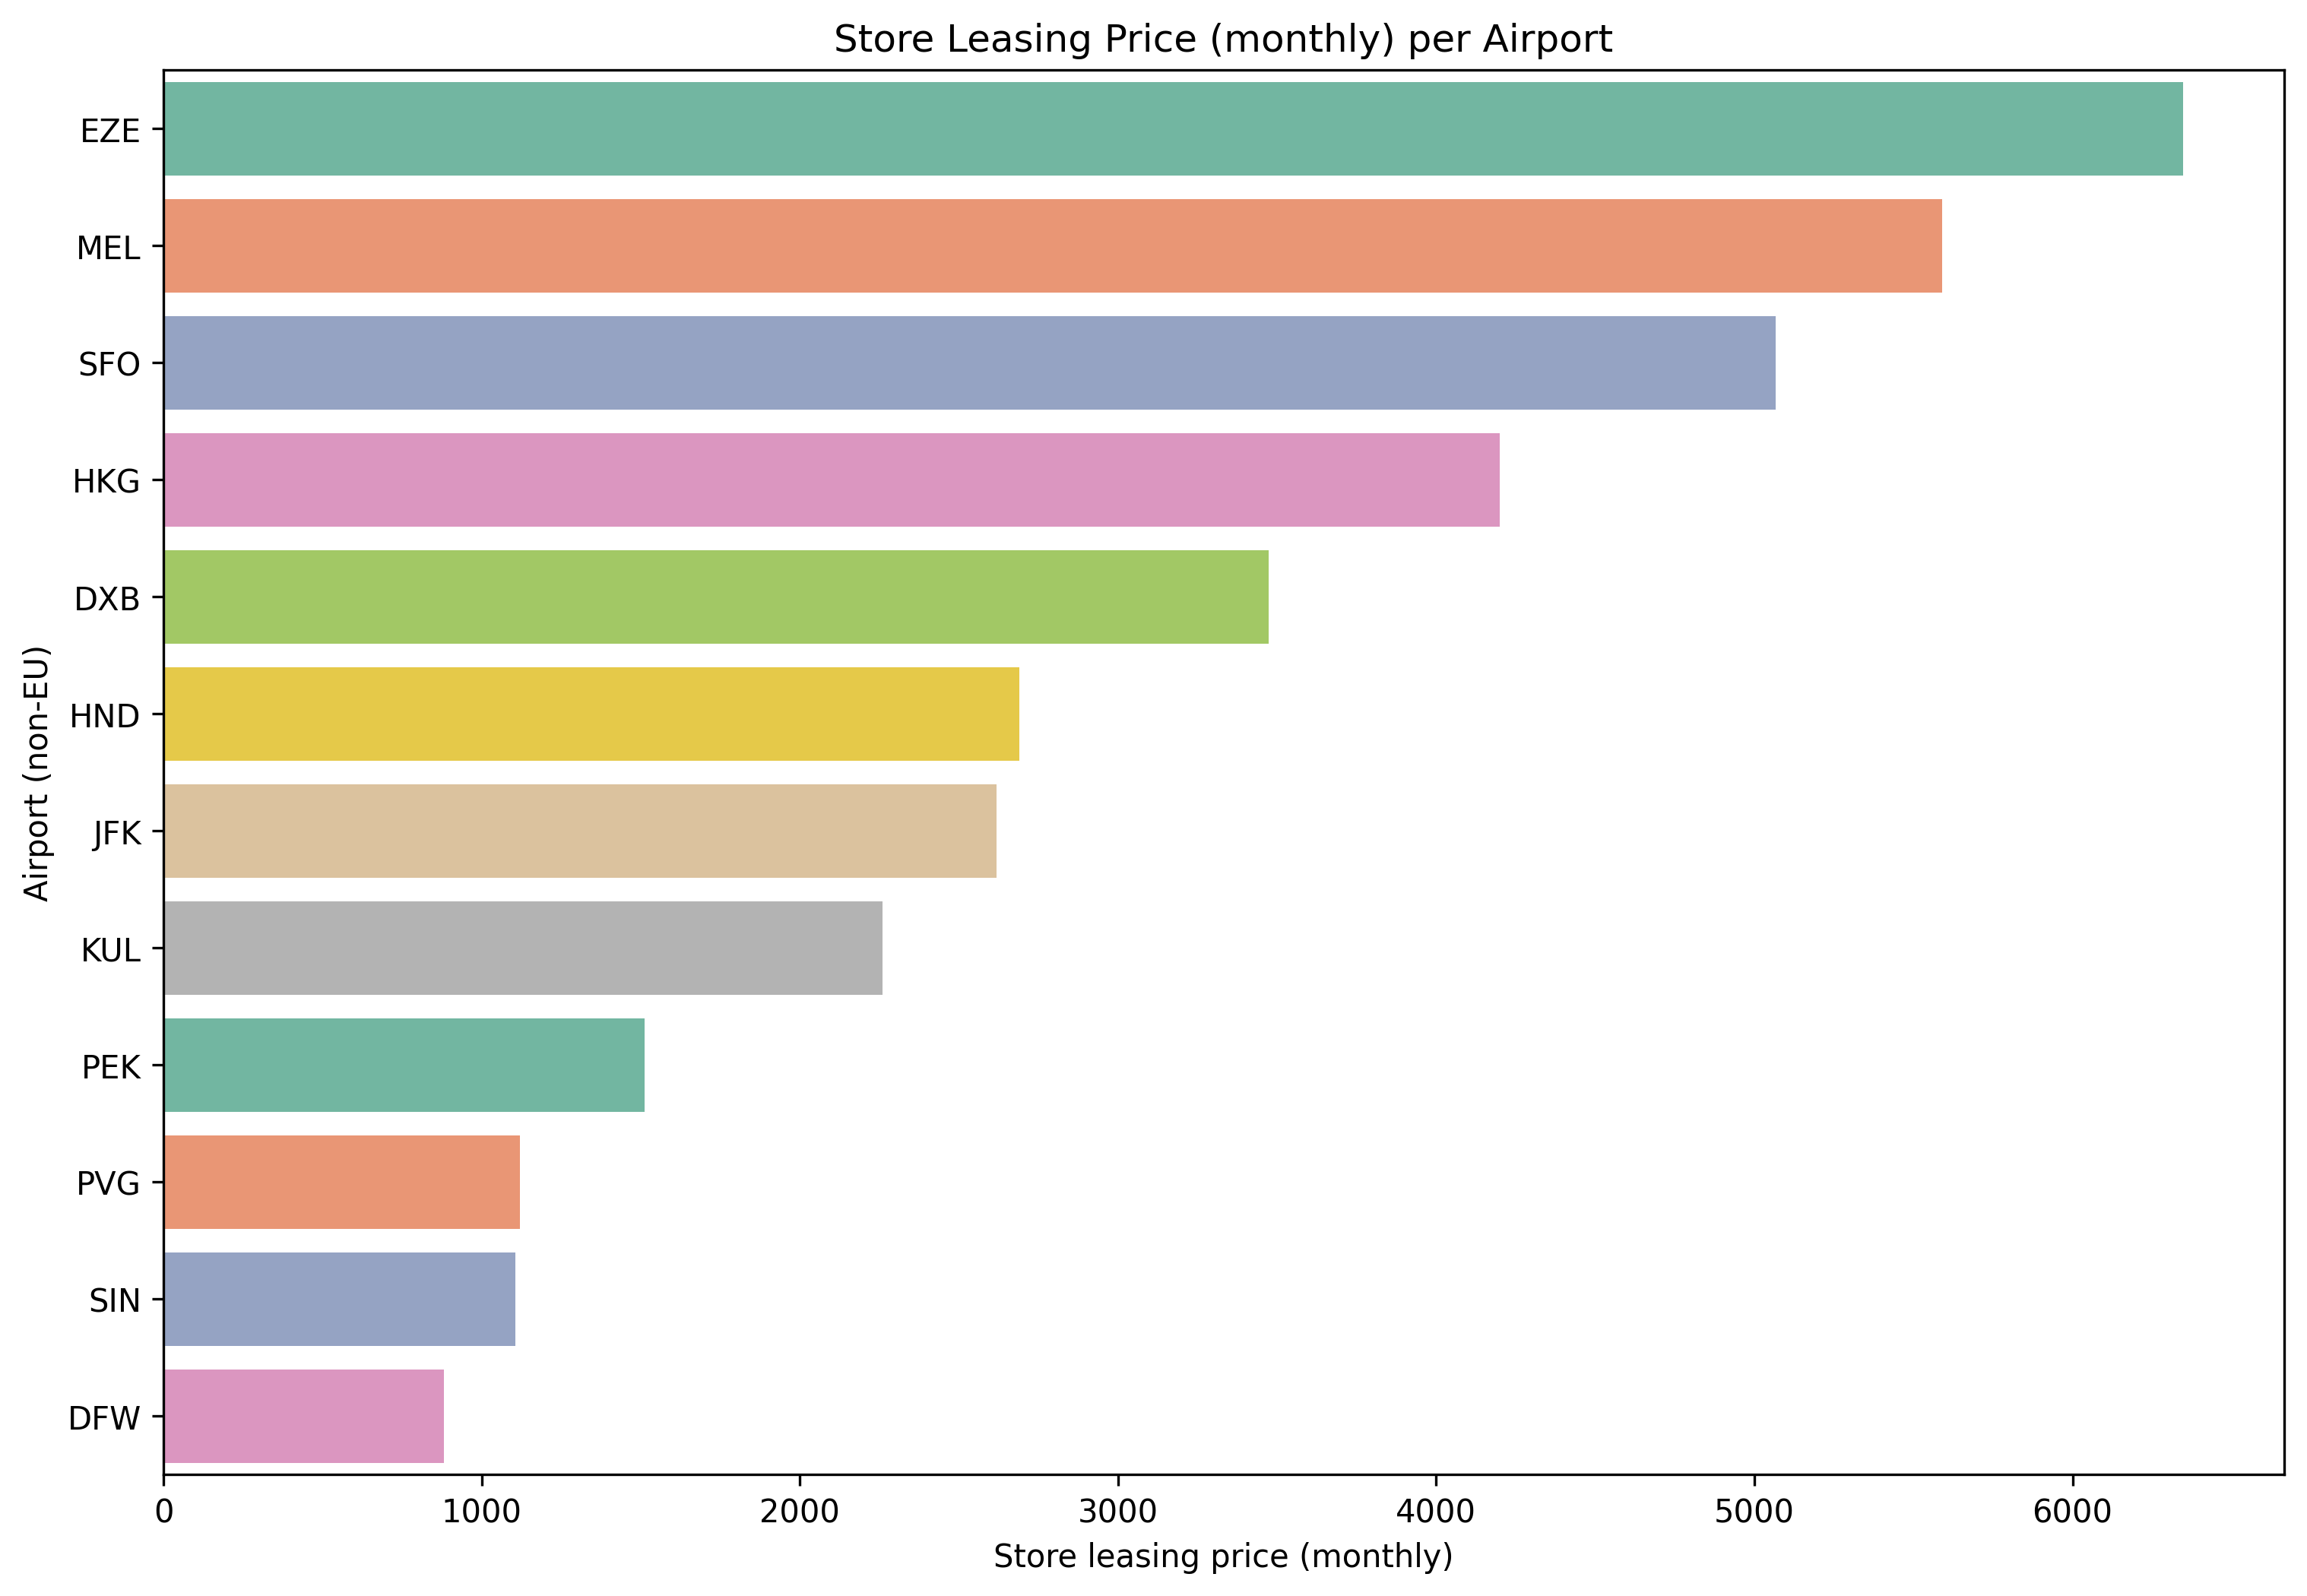

In [56]:
#   Generate leasing_price_per_month for each airport (non-EU) 

airports_tol_table["leasing_price_per_month"] = np.multiply(airports_tol_table["sqm of store"].astype(float), 
                                                            airports_tol_table["price per sqm/month"].astype(float))

display(airports_tol_table)


airports_tol_table_sorted = airports_tol_table.sort_values(by='leasing_price_per_month', 
                                                           ascending=False)

plt.figure(figsize=(12, 8), dpi=300)
sns.barplot(data=airports_tol_table_sorted, 
            x='leasing_price_per_month',
            y='Airport', 
            palette='Set2')
plt.title('Store Leasing Price (monthly) per Airport')
plt.xlabel('Store leasing price (monthly)')
plt.ylabel('Airport (non-EU)')
plt.show()
